In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Any results you write to the current directory are saved as output.

/kaggle/input/fast-ai-inceptionresnetv2/__results__.html
/kaggle/input/fast-ai-inceptionresnetv2/inceptionresnetv2_stage-1.pth
/kaggle/input/fast-ai-inceptionresnetv2/tmp.pth
/kaggle/input/fast-ai-inceptionresnetv2/__notebook__.ipynb
/kaggle/input/fast-ai-inceptionresnetv2/submissioninceptionresnetv2.csv
/kaggle/input/fast-ai-inceptionresnetv2/custom.css
/kaggle/input/fast-ai-inceptionresnetv2/__output__.json
/kaggle/input/fast-ai-inceptionresnetv2/__results___files/__results___14_1.png
/kaggle/input/fast-ai-inceptionresnetv2/__results___files/__results___5_0.png
/kaggle/input/fast-ai-inceptionresnetv2/__results___files/__results___11_2.png
/kaggle/input/fast-ai-inceptionresnetv2/__results___files/__results___14_2.png
/kaggle/input/ifood-2019-fgvc6/sample_submission.csv
/kaggle/input/ifood-2019-fgvc6/class_list.txt
/kaggle/input/ifood-2019-fgvc6/train_set.zip
/kaggle/input/ifood-2019-fgvc6/train_labels.csv
/kaggle/input/ifood-2019-fgvc6/ifood2019_sample_submission.csv
/kaggle/input/ifo

In [2]:
from zipfile import ZipFile
import shutil

if not os.path.exists("./train_set"):
    for file_name in ['train_set.zip', 'val_set.zip', 'test_set.zip']:
        with ZipFile('../input/ifood-2019-fgvc6/' + file_name, 'r') as zipObj:
            print("unzipping", file_name)
            zipObj.extractall('./')

for dirname, _, _ in os.walk('./'):
    print(dirname)

unzipping train_set.zip
unzipping val_set.zip
unzipping test_set.zip
./
./train_set
./val_set
./test_set


In [3]:
! pip install pretrainedmodels
%reload_ext autoreload
%autoreload 2
%matplotlib inline  

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
from matplotlib import style
import seaborn as sns

style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.utils import shuffle

     |████████████████████████████████| 61kB 2.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=f84aec3d92ba2d67b6fa4a509204bebf15706a6d43d08b3c0e77a2e0cb9c673c
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [4]:
df_train = pd.read_csv('../input/ifood-2019-fgvc6/train_labels.csv')
df_val   = pd.read_csv('../input/ifood-2019-fgvc6/val_labels.csv')
df_test = pd.read_csv('../input/ifood-2019-fgvc6/sample_submission.csv')
df_train['path'] = df_train['img_name'].map(lambda x: os.path.join('./train_set/', x))
df_val['path'] = df_val['img_name'].map(lambda x: os.path.join('./val_set/', x))
df_test['path'] = df_test['img_name'].map(lambda x: os.path.join('./test_set/', x))

df = pd.concat([df_train, df_val], ignore_index=True)
val_idx = [i for i in range(len(df_train), len(df))]
df.head()

,img_name,label,path
0,train_101733.jpg,211,./train_set/train_101733.jpg
1,train_101734.jpg,211,./train_set/train_101734.jpg
2,train_101735.jpg,211,./train_set/train_101735.jpg
3,train_101736.jpg,211,./train_set/train_101736.jpg
4,train_101737.jpg,211,./train_set/train_101737.jpg


In [5]:
input_size = 299
batch_size = 32
num_classes = df_train['label'].nunique()
np.random.seed(78)

tfms = get_transforms(do_flip=True, max_rotate=360, max_zoom=1.2, 
                      max_lighting=0.5, p_lighting=0.5, p_affine=0.5)
data= (ImageList.from_df(df=df, path='./', cols='path') #get dataset from dataset
       .split_by_idx(val_idx)
       .label_from_df(cols='label') #obtain labels from the level column
       .add_test_folder('./test_set')
       .transform(tfms, size=input_size, resize_method=ResizeMethod.SQUISH, padding_mode='border') #Data augmentation
        .databunch(bs=batch_size, num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

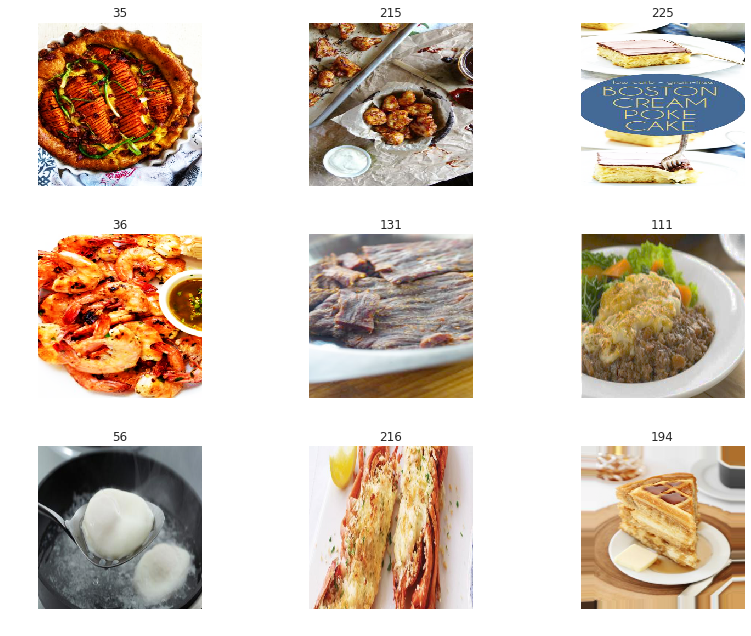

In [6]:
data.show_batch(rows=3, figsize=(12,9))

In [7]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [8]:
def top_3_accuracy(preds, targs):
    return top_k_accuracy(preds, targs, 3)

In [9]:
from torchvision import models as torchmodels
import pretrainedmodels

print(pretrainedmodels.__dict__.keys())
print()
print(torchmodels.__dict__.keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'version', '__version__', 'models', 'datasets', 'pretrained_settings', 'model_names', 'fbresnet152', 'cafferesnet101', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'nasnetalarge', 'nasnetamobile', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'pnasnet5large', 'polynet'])

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'utils', 'alexnet', 'AlexNet',

In [10]:
from torchvision import models as torchmodels

# model_name = 'se_resnext101_32x4d'
# model_name = 'resnext101_32x8d'
model_name = 'inceptionresnetv2'

! mkdir -p /root/.cache/torch/checkpoints
# ! cp ../input/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth /root/.cache/torch/checkpoints/se_resnext101_32x4d-3b2fe3d8.pth
# ! cp ../input/pretrainedmodels/pnasnet5large-bf079911.pth /root/.cache/torch/checkpoints/pnasnet5large-bf079911.pth
! cp ../input/pretrainedmodels/inceptionresnetv2-520b38e4.pth /root/.cache/torch/checkpoints/inceptionresnetv2-520b38e4.pth

# def pnasnet5large(pretrained=False, output_classes=1):
#     pretrained = 'imagenet' if pretrained else None
#     model = pretrainedmodels.__dict__['pnasnet5large'](num_classes=1000, pretrained='imagenet')
#     new_last_linear = nn.Linear(model.last_linear.in_features, output_classes)
#     model.last_linear = new_last_linear
#     return model

def get_model(pretrained=True, model_name=model_name):
    pretrained = 'imagenet' if pretrained else None
    return pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=pretrained)
#     arch = torchmodels.__dict__[model_name](pretrained=pretrained)

In [11]:
learner = None
# if model_name == 'pnasnet5large':
#     learner = cnn_learner(data, pnasnet5large, 
#                           metrics=[top_3_accuracy], model_dir='./', 
#                           loss_func = LabelSmoothingCrossEntropy()).mixup()
# else:
learner = cnn_learner(data, get_model, metrics=[top_3_accuracy], model_dir='./', 
                      loss_func = LabelSmoothingCrossEntropy()).mixup()

In [12]:
# learner.lr_find()
# learner.recorder.plot(suggestion=True)

In [13]:
# stage = 1
# csvlogger = callbacks.CSVLogger(learn=learner, 
#                                 filename='history_stage_'+str(stage)+'_'+model_name, 
#                                 append=True)
# saveModel = callbacks.SaveModelCallback(learner, 
#                                         every='epoch',
#                                         monitor='top_3_accuracy', 
#                                         mode='max',
#                                         name='stage_'+str(stage))
# reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learner, 
#                                                monitor='top_3_accuracy', 
#                                                mode='max', 
#                                                patience=1, 
#                                                factor=0.5)

In [14]:
# lr = 3e-3
# learner.fit_one_cycle(5, slice(lr))

In [15]:
# learner.recorder.plot_losses()
# learner.recorder.plot_metrics()
# learner.save(model_name+'_stage-1', return_path=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.31E-06


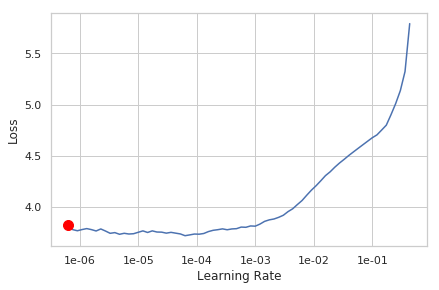

In [16]:
learner.load('../input/fast-ai-inceptionresnetv2/inceptionresnetv2_stage-1')

learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [17]:
stage = 2
csvlogger = callbacks.CSVLogger(learn=learner, 
                                filename='history_stage_'+str(stage)+'_'+model_name, 
                                append=True)
saveModel = callbacks.SaveModelCallback(learner, 
                                        every='epoch',
                                        monitor='top_3_accuracy', 
                                        mode='max',
                                        name='stage_'+str(stage))
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learner, 
                                               monitor='top_3_accuracy', mode='max', 
                                               patience=1, 
                                               factor=0.5)


In [18]:
learner.fit_one_cycle(3, slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,top_3_accuracy,time
0,3.730941,2.400828,0.785476,57:04


PosixPath('inceptionresnetv2_stage-2.pth')

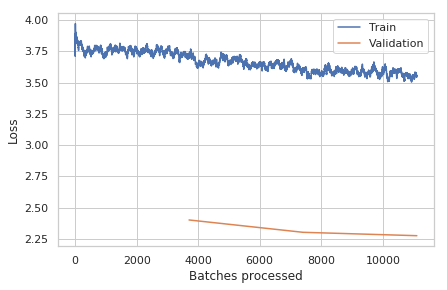

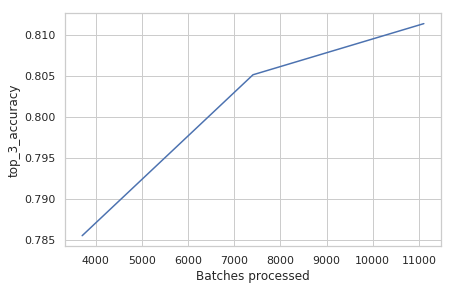

In [19]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()
learner.save(model_name+'_stage-2', return_path=True)

In [20]:
preds, _ = learner.get_preds(ds_type=DatasetType.Test)
fnames = [f.name for f in learner.data.test_ds.items]
test_df = pd.DataFrame(fnames, columns=['img_name'])
test_df['label'] = ''
predictions = np.array(preds).reshape(len(preds), 251)

from tqdm import tqdm_notebook as T
for i, pred in T(enumerate(predictions), total=len(predictions)):
    test_df.loc[i, 'label'] = ' '.join(str(int(i)) for i in np.argsort(pred)[::-1][:3])
    
test_df.to_csv('submission'+model_name+'.csv', index=False)
test_df.head(15)

,img_name,label
0,test_016403.jpg,37 9 189
1,test_027031.jpg,122 228 175
2,test_023199.jpg,8 234 151
3,test_017486.jpg,110 129 13
4,test_008560.jpg,108 198 140
5,test_018710.jpg,144 62 201
6,test_000311.jpg,97 91 205
7,test_018228.jpg,62 46 120
8,test_008806.jpg,214 176 218
9,test_003382.jpg,179 27 165


In [21]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(test_df, filename='submission_SE_Resnext101_fastai.csv')

In [22]:
for path in ["./train_set", "./val_set", "./test_set"]:
    shutil.rmtree(path)